1. get filelist of orthophotos over Helsinki from Paituli
2. check email, download filelist
3. use wget -i filelist to download files (did not work for me directly; downloaded one by one with wget)
4. -> GeoML/data/orthophotos
5. same for MTK (whole Finland); takes minutes, better provide already clipped version on Allas or OSM
6. -> GeoML/data/MTK

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


array([ 376718.61018759, 6644566.39931673,  403517.04394148,
       6685896.19821728])

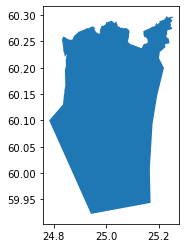

In [80]:
# Specify the name that is used to seach for the data
place_name = "Helsinki, Finland"
# import osmnx
import osmnx as ox
import geopandas as gpd

# Get place boundary related to the place name as a geodataframe
area = ox.geocode_to_gdf(place_name)
# Check the data type
area
area.plot()
area.bounds
area.crs
areaETRS = area.to_crs({'init':'epsg:3067'})
areaETRS.total_bounds

In [ ]:
# List key-value pairs for tags
tags = {'building': True}   

buildings = ox.geometries_from_place(place_name, tags)
buildings = buildings.to_crs({'init':'epsg:3067'})
buildings.head()
# Plot footprints 
buildings.plot()

In [ ]:
# List key-value pairs for tags
tags = {'natural': 'water'}   

water = ox.geometries_from_place(place_name, tags)
water = water.to_crs({'init':'epsg:3067'})
water.head()
# Plot footprints 
water.plot()

In [ ]:
# List key-value pairs for tags
tags = {'leisure': 'park'}   

park = ox.geometries_from_place(place_name, tags)
park = park.to_crs({'init':'epsg:3067'})
park.head()
# Plot footprints 
park.plot()

In [70]:
from rasterio.merge import merge
merged = merge(['../data/orthophotos/L4133A.jp2', '../data/orthophotos/L4133B.jp2', '../data/orthophotos/L4133C.jp2', '../data/orthophotos/L4133D.jp2'], bounds= (376718.61018759, 6644566.39931673,  403517.04394148,
       6685896.19821728))

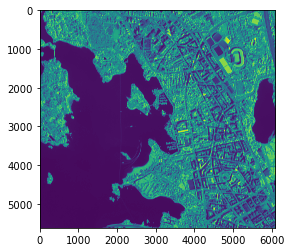

In [71]:
# read only part of the vrt
import rasterio
from rasterio.windows import from_bounds
from matplotlib import pyplot
#vrt_path = "my.vrt"
#with rasterio.open(vrt_path) as src:
    #rst = src.read(window=from_bounds(382503.10420442, 6671842.56125306,  385545.07257462,6674654.56243394, src.transform))
rst = merged
pyplot.imshow(rst[0][0])

with rasterio.open('../data/orthophotos/L4133A.jp2', 'r') as src:
    crs = src.crs

with rasterio.open('toolo.tif', 'w', driver='GTiff',
    height= rst[0].shape[1],
    width= rst[0].shape[2],
    count=rst[0].shape[0],
    dtype=rst[0].dtype,
    crs=crs,
    transform=rst[1]) as dst:
        dst.write(rst[0]  )

In [72]:
# create class label column for each class; 1:park,2:building,3:water 
park['class'] = 1
buildings['class'] = 2
water['class'] = 3

In [73]:
#drop all other columns
park.drop(park.columns.difference(['geometry','class']), axis =1, inplace=True)
buildings.drop(buildings.columns.difference(['geometry','class']),axis= 1, inplace=True)
water.drop(water.columns.difference(['geometry','class']), axis=1, inplace=True)

In [74]:
# create class vectorfile
classes = park.append(water)
classes = classes.append(buildings)
classes.shape

/run/nvme/job_12561462/tmp/ipykernel_137323/3835823683.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classes = park.append(water)
/run/nvme/job_12561462/tmp/ipykernel_137323/3835823683.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classes = classes.append(buildings)


(910, 2)

In [77]:
# rasterize

import rasterio
from rasterio import features
import numpy
from rasterio.enums import MergeAlg
#copy and update the metadata from the input raster for the output
with rasterio.open('toolo.tif') as src:
    meta = src.meta.copy()
    meta.update(count=1)
    shape = src.read(1).shape
    transform = src.transform

#Now burn the features into the raster and write it out

outname = 'classes.tif'

with rasterio.open(outname, 'w+', **meta) as out:

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(classes.geometry, classes['class']))

    #burned = features.rasterize(shapes=shapes, fill=10, out_shape = shape, out=None, transform=out.transform, all_touched =True, default_value= 100, dtype="uint8")

    rasterized = features.rasterize(shapes,
                                out_shape = shape,
                                transform = transform,
                                all_touched = True,
                                fill = -5,   # background value
                                merge_alg = MergeAlg.replace,
                                dtype = numpy.int16)

    print(numpy.unique(rasterized))
    out.write_band(1, rasterized)



[-5  1  2  3]


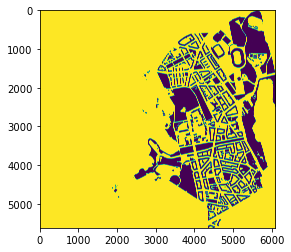

In [79]:
from matplotlib import pyplot
import rasterio
from rasterio.plot import show_hist
with rasterio.open('classes.tif','r') as src:
    pyplot.imshow(src.read(1))

(4, 5)

In [ ]:
# create class vectorfile
water, park/grass/vegetation, building, streets?
-> look for largerpart/full of helsinki with all of them; run the model later on different part of Helsinki or other city Turku/Tampere and then totally different 
same with Sentinel-2 image?
-> create raster with classes
